<a href="https://colab.research.google.com/github/nir6760/MScProjects/blob/main/GMDL_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GMDL , OSR Project

**Nir Mualem 205467780**

**Or Cohen Tsemach 207498395**

## Directory & File Stracture:
```
├── GMDL_proj.ipynb
├── models.py
├── train_model.py
├── eval_model.py
├── utils.py
├── openSet.pth
├── closeSet.pth

```



In [ ]:
# # Comment it out to mount the files from drive (require permission), or just manually add them to the current directory
# from google.colab import drive
# drive.mount('/content/drive/')
# import sys
# sys.path.insert(0,'./drive/MyDrive/Colab_Notebooks/GMDL/GMDL_PROJ')
# Don't forget to add the pth files to the working directory for loading the models

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Comment it out if you are going to use wandb (requires permission)
# import wandb
# wandb.login()

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import os

from models import AnchorsNet, ConvNet
from train_model import train_anchors, train_conv
from eval_model import eval_osr_csr
from utils import *

### Random seeds (for reproducibility)

In [ ]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Runs on : {device}')


Runs on : cuda:0


In [ ]:
# configuration
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

config = dict(
    epochs_anchors=0,
    epochs_conv=70,
    alpha_magnitude = 100,
    num_classes=10,
    num_output_eurons=2,
    batch_size=32,
    learning_rate=0.001,
    learning_rate_conv=0.001,
    weight_decay=5e-5,
    lbda_anchor_loss=0.2,
    resume=None, # None or model name
    save_models=None, # None or model name
    init_weights=True,
    dataset="MNIST",
    unknown_dataset1="FMNIST",
    unknown_dataset2="CIFAR10",
    use_wandb_flag=False,
    project_name="GMDL_OSR",# used only for wandb
    run_name='run70', # used only for wandb
    trial=0, # for debugging use
    ood_score_threshold=0.96)
config = AttrDict(config)

## Data & Preprocessing

In [ ]:
def get_data(data_name='MNIST'):
  # Define the mandatory transformations
  # augmentation
    mnist_mean = 0.1307
    mnist_std = 0.3081
    mnist_rotate = 7
    mnist_scale_min = 0.7
    test_transform = None
    if data_name == 'MNIST':
        scale_min = mnist_scale_min
        rotate = mnist_rotate
        means = mnist_mean
        stds = mnist_std
        transform_dict = {
                'train': transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.RandomAffine(degrees=rotate, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                    transforms.ToTensor(),
                    transforms.Normalize(means, stds),

                ]),
                'val': transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.ToTensor(),
                    transforms.Normalize(means, stds)
                ]),
                'test': transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.ToTensor(),
                    transforms.Normalize(means, stds)
                ])
            }
        test_transform = transform_dict['test']
    else:
        transform_ood = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # OOD mean and std
        ])
        test_transform = transform_ood

    train_dataset =None
    val_dataset = None
    test_dataset =None
    if data_name == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root="./data",
                                                  train=True,
                                                  transform=transform_dict['train'],
                                                  download=True)
        val_dataset = torchvision.datasets.MNIST(root="./data",
                                                  train=True,
                                                  transform=transform_dict['val'],
                                                  download=True)
        test_dataset = torchvision.datasets.MNIST(root="./data",
                                                  train=False,
                                                  transform=transform_dict['test'],
                                                  download=True)
    else:
        if data_name == 'FMNIST':
            test_dataset = torchvision.datasets.FashionMNIST(root="./data",
                                                    train=False,
                                                    transform=transform_ood,
                                                    download=True)
            # Modify the labels to 10
            for i in range(len(test_dataset.targets)):
                test_dataset.targets[i] = 10
        elif data_name == 'CIFAR10':
            # CIFAR10
            test_dataset = torchvision.datasets.CIFAR10(root="./data",
                                                    train=False,
                                                    transform=transform_ood,
                                                    download=True)
            # Modify the labels to 10
            for i in range(len(test_dataset.targets)):
                test_dataset.targets[i] = 10
    return train_dataset, val_dataset, test_dataset, test_transform


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader

def make_loaders(config, ood_data=None):
    # CIFAR10 and FMNIST return only test_dataset
    # Make the data
    train_loader = None
    val_loader = None
    test_loader = None
    train_dataset = None
    if ood_data is not None:
        _, _, test_dataset, _ = get_data(ood_data)
        test_loader = make_loader(test_dataset, batch_size=config.batch_size)
    else:
        train_dataset, val_dataset, test_dataset, _ = get_data(config.dataset)
        train_loader = make_loader(train_dataset, batch_size=config.batch_size)
        val_loader = make_loader(val_dataset, batch_size=config.batch_size)
        test_loader = make_loader(test_dataset, batch_size=config.batch_size)
    return train_loader, val_loader, test_loader, train_dataset

def merge_loaders(config, loader1, loader2, num_samples=1000):
    # Merge the datasets and take randomly 1000-2000 samples
    merged_dataset = torch.utils.data.ConcatDataset([loader1.dataset, loader2.dataset])
    sampled_indices = torch.randperm(len(merged_dataset))[:num_samples]
    ood_sampled_test_set = torch.utils.data.Subset(merged_dataset, sampled_indices)
    # Create a new data loader from the merged dataset
    merged_loader = torch.utils.data.DataLoader(ood_sampled_test_set, batch_size=config.batch_size, shuffle=False, num_workers=2)
    return merged_loader


def plot_some_images(data_loader, title='MNIST'):
        # Get a batch of training data
    images, labels = next(iter(data_loader))
    # Define the class labels
    class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'OOD']
    # Plot the images with labels
    num_images_row = 5
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_images_row, figsize=(10, 3))
    images_iter = 0
    for r in range(0,num_rows):
        for i in range(0,num_images_row):

            # Convert the image tensor to a NumPy array
            image = images[images_iter].numpy()

            # Convert the image from channel-first to channel-last format
            image = np.transpose(image, (1, 2, 0))

            # Rescale the image pixel values from [-1, 1] to [0, 1]
            image = (image + 1) / 2.0
            # Plot the image
            axes[r,i].imshow(image, cmap='gray')
            axes[r,i].axis('off')
            axes[r,i].set_title(f'{title}: {class_labels[labels[images_iter]]}')
            images_iter += 1

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


### Examples of MNIST dataset and OOD dataset

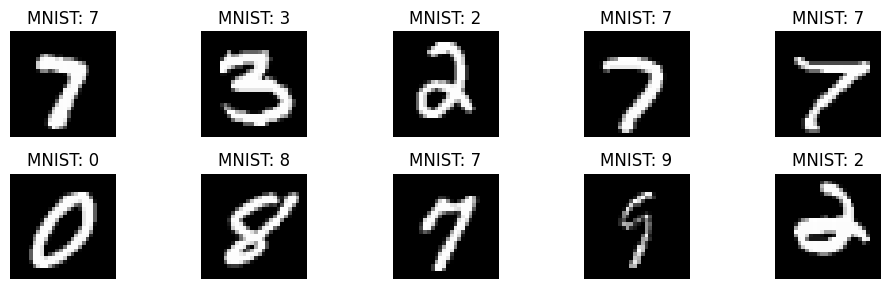

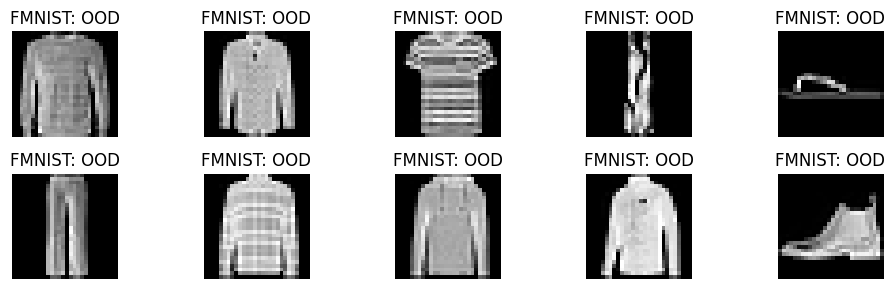

Files already downloaded and verified


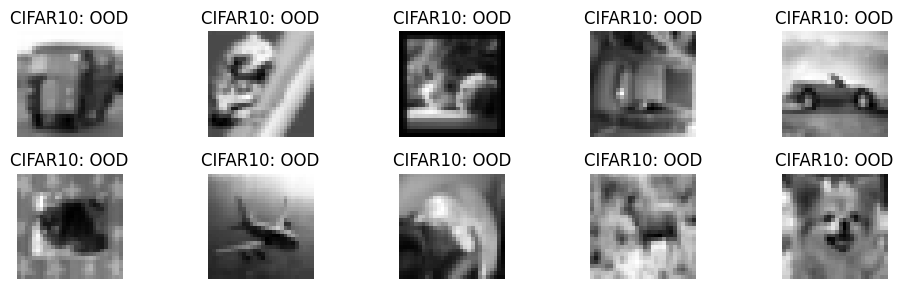

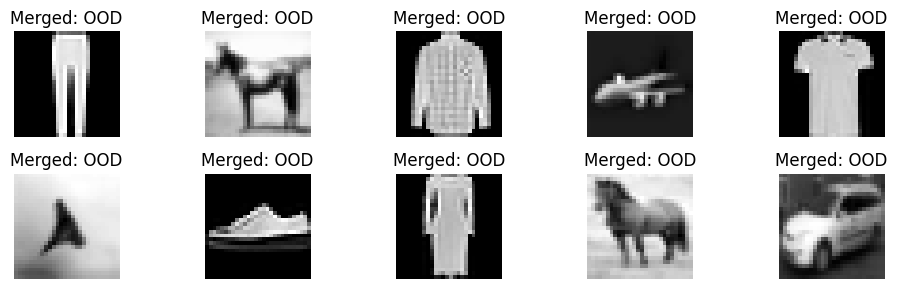

In [ ]:
# make the model, data, and optimization problem
train_loader, val_loader, test_loader, mnist_dataset = make_loaders(config)
plot_some_images(test_loader, title=config.dataset)
_, _, test_loader_unknown1, _ = make_loaders(config, config.unknown_dataset1)
plot_some_images(test_loader_unknown1, title=config.unknown_dataset1)
_, _, test_loader_unknown2, _ = make_loaders(config, config.unknown_dataset2)
plot_some_images(test_loader_unknown2, title=config.unknown_dataset2)
test_loader_unknown = merge_loaders(config, test_loader_unknown1, test_loader_unknown2)
plot_some_images(test_loader_unknown, title='Merged')

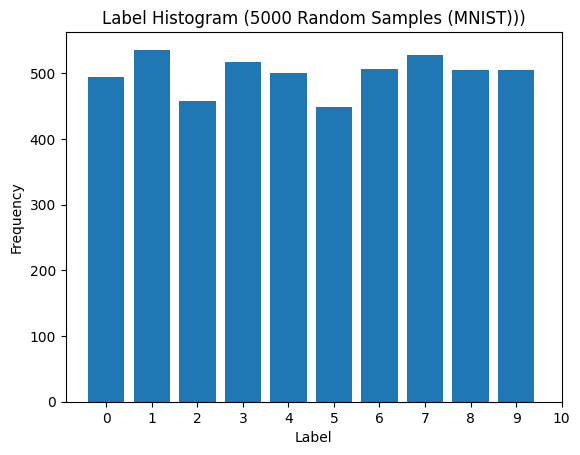

In [ ]:
mnist_full_loader = make_loader(mnist_dataset, batch_size=len(mnist_dataset))
plotHistogram(mnist_full_loader, sampled = 5000)

## Models

In [ ]:
def make_anchors_model(config):
    print('==> Building Anchors Network..')
    model = AnchorsNet(num_output_eurons=config.num_output_eurons, init_weights=config.init_weights)
    return model

def make_conv_model():
    print('==> Building Conv Network..')
    model = ConvNet()
    return model

def load_model(model_wts):
    model = make_conv_model()
    model.load_state_dict(model_wts) # load the best model for validation
    return model

def load_model_pth(device, open=True):
    #assert os.path.isdir('weights'), 'Error: no checkpoint directory found!'
    if open:
        print('Loading model for open set:')
        checkpoint = torch.load('openSet.pth')
        model = make_conv_model()

    else:
        print('Loading model for close set:')
        checkpoint = torch.load('closeSet.pth')
        model = make_conv_model()
    model = model.to(device)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['net'].items() if k in model_dict}
    model.load_state_dict(pretrained_dict) # load the best model for validation
    return model


## Training

In [ ]:
def model_pipeline_aux(config, train_loader, val_loader,
                       use_wandb_flag=False, wandb=None):
    if use_wandb_flag:
      config = wandb.config

    # Anchors Model - first attempt
    # model_anchors = make_anchors_model(config)
    # anchors_optimizer = optim.SGD(model_anchors.parameters(), lr = config.learning_rate,
		# 						momentum = 0.9, weight_decay = config.weight_decay)
    #anchors_ optimizer = optim.Adam(model_anchors.parameters(), lr=config.learning_rate_conv)
    #best_model_wts_anchors =  None #train_anchors(train_loader, val_loader, model_anchors, device, config, anchors_optimizer, wandb)

    # Conv Model
    model_conv = make_conv_model()
    conv_criterion = nn.CrossEntropyLoss()
    conv_optimizer = optim.Adam(model_conv.parameters(), lr=config.learning_rate_conv)
    #conv_optimizer = optim.SGD(model_conv.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=config.weight_decay)
    conv_scheduler = None#torch.optim.lr_scheduler.ExponentialLR(conv_optimizer, gamma=0.3)
    best_model_wts_conv, loss_acc_dict_conv = train_conv(train_loader, val_loader, model_conv, device, config, conv_criterion, conv_optimizer, conv_scheduler, wandb)
    print('Done!')
    return best_model_wts_conv, loss_acc_dict_conv

In [ ]:
def model_pipeline(config, train_loader, val_loader):
  use_wandb_flag = config.use_wandb_flag
  if use_wandb_flag:
    with wandb.init(project=config.project_name, name=config.run_name, config=config):
      return model_pipeline_aux(config, train_loader, val_loader, use_wandb_flag, wandb)
  else:
      return model_pipeline_aux(config, train_loader, val_loader, use_wandb_flag)


In [ ]:
best_model_wts_conv, loss_acc_dict_conv = model_pipeline(config, train_loader, val_loader)

==> Building Conv Network..
Epoch [1/70],train - Loss: 0.0585, Accuracy 98.1843% || val - Accuracy 99.2250 %
Epoch [10/70],train - Loss: 0.0304, Accuracy 99.0814% || val - Accuracy 99.5600 %
Epoch [20/70],train - Loss: 0.0238, Accuracy 99.2157% || val - Accuracy 99.6717 %
Epoch [30/70],train - Loss: 0.0209, Accuracy 99.3757% || val - Accuracy 99.7483 %
Epoch [40/70],train - Loss: 0.0191, Accuracy 99.3986% || val - Accuracy 99.7633 %
Epoch [50/70],train - Loss: 0.0167, Accuracy 99.4529% || val - Accuracy 99.7933 %
Epoch [60/70],train - Loss: 0.0160, Accuracy 99.4457% || val - Accuracy 99.8033 %
Epoch [70/70],train - Loss: 0.0157, Accuracy 99.4957% || val - Accuracy 99.7883 %
Done!


## Evaluation

In [ ]:
best_model_base = load_model_pth(device, open=False) # load_model(best_model_wts_conv)
best_model_conv = load_model_pth(device, open=True)  # load_model(best_model_wts_conv)

Loading model for close set:
==> Building Conv Network..
Loading model for open set:
==> Building Conv Network..


In [ ]:
y_train, predicteds_conv_train_ood,\
yK, predicteds_convK_ood,\
yU, predicteds_convU_ood,\
embeddings_logits_conv_train,embeddings_logits_convK, embeddings_logits_convU,\
predicteds_conv_base_train, predicteds_conv_baseK, predicteds_conv_baseU\
=eval_osr_csr(train_loader, test_loader, test_loader_unknown,
                                                         best_model_base, best_model_conv,
                                                         device, config, wandb=None)

==> Evaluating network accuracy for trial 0..
Done!


### Computer Exercise 1

#### BASELINE: MNIST dataset (train)

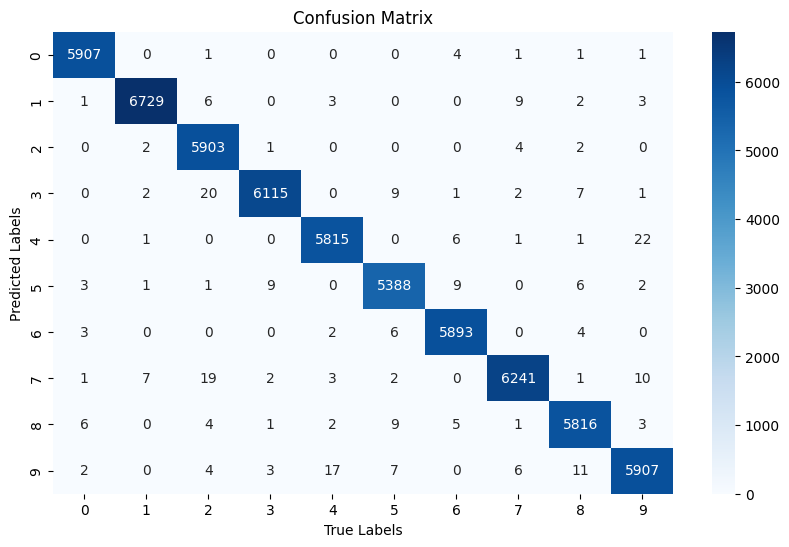

Accuracy (BASELINE, MNIST-train : 99.5233 %


In [ ]:
confusionMatrix(predicteds_conv_base_train, y_train, baseline=True, title=f'(BASELINE, {config.dataset}-train')

BASELINE: MNIST dataset (test)

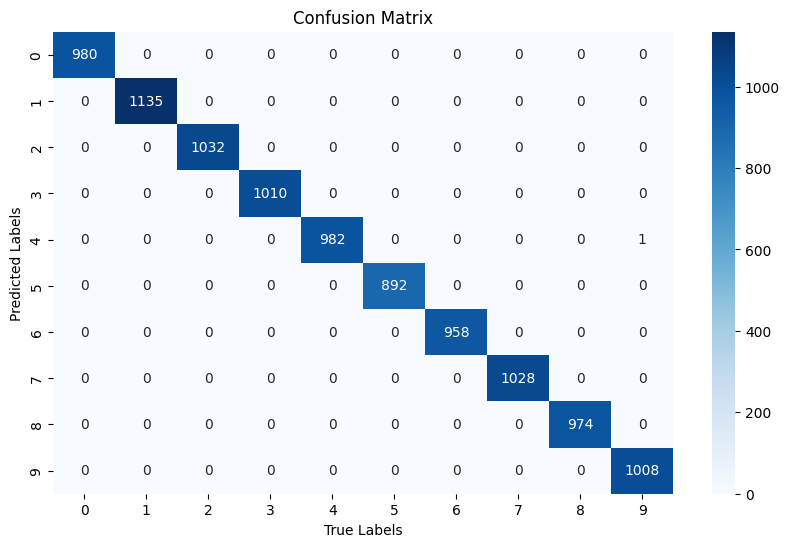

Accuracy (BASELINE, MNIST-test : 99.99 %


In [ ]:
confusionMatrix(predicteds_conv_baseK, yK, baseline=True, title=f'(BASELINE, {config.dataset}-test')

### Computer Exercise 2 (OSR model was trained above, this is only the mapping function)

In [ ]:
def map_output_to_label(preds):
    output_labels = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 'Unknown'}
    mapped_output = [output_labels[p] for p in preds]
    return mapped_output
# Example for the mapping function
# predicteds_convU_ood is the predictions for the unknown-test data (0-10 classes)
mapped_output = map_output_to_label(predicteds_convU_ood)
unknown_cnt = mapped_output.count('Unknown')
print(f'Accuracy for unknown-test set: {round(100*unknown_cnt/len(mapped_output),4)}%')

Accuracy for unknown-test set: 98.9%


### OSR Method

#### First attempt:

Initially, we attempted to implement a technique inspired by the paper "Class Anchor Clustering: A Loss for Distance-based Open Set Recognition" (Miller et al.). The method, known as CAC, involves training known classes to form compact clusters around class-specific centers in the logit space using predefined anchors. It enhances the distinction between known and unknown classes by utilizing a combination of triplet loss and anchor loss, which encourage images to be closer to their respective anchor points in the logit space. This approach aims to promote tight clustering while maintaining classification accuracy.

We applied this concept by embedding the data in a 2D space for visualization, but the same principle can be extended to higher dimensions (in our experiments we tried it too). However, we encountered a limitation with this approach, wherein the unknown dataset tends to cluster near the anchors assigned to challenging classes. This method can only yield successful results if the unknown data shares some related features with the known data, which cannot be assumed in our specific case.


In our initial attempt, we observed that the separation between the known classes in the embedding space was well-defined. Consequently, the out-of-distribution (OOD) data points were expected to be located far away from each class center. However, upon further analysis, we noticed that in the second plot, the OOD data points were predominantly scattered across the challenging classes, such as the digits 8 and 1, resulting in an extended distribution of OOD data within these classes.

In the PDF format, the figures are in the supplementary section (last three pages).

First figure: The 2D embedded data without the unknown class (10)

Second figure: The 2D Embedded Data with the unknown class (10)





![figure1](https://drive.google.com/uc?id=1if_Y6156TKOC9zhoD7VsxJ6oZIkLJRXw)

![figure2](https://drive.google.com/uc?id=1cQ9jJirN7zRecanl79aCnFZjTGmzN2Dk)

#### Selected Method
To address the issue of the our first attempt, we devised an alternative solution.
Initially, we used two models: one based on anchors and another based on the uncertainty of classification. The latter model used a standard cross-entropy loss in the 10-dimensional space and a soft-max function for getting the confidence score as well. Surprisingly, our second model performed significantly better on its own. By carefully selecting an appropriate threshold, determined through extensive experimentation, we achieved promising results for both baseline classification and out-of-distribution classification.

 We employed a model architecture comprising convolutional layers, max pooling, and a fully-connected layer, as described in the model overview. The main goal of training the model was to differentiate out-of-distribution (ood) data by applying a hyperparameter threshold to identify uncertain images. To improve the model's ability to separate ood data, we found that training it for a shorter duration (5-10 epochs) yielded better results by preventing overfitting. In addition to this initial training, we conducted an extensive training phase (70-80 epochs) using the same model architecture as an ensemble approach to ensure accurate classification of in-distribution data into their respective classes.

 We used data augmentations such as rotation and scaling for better generalization, we implemnted it by randomly augment the training data. Also, in our model we used batch normalization "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" (IOFFE et al.). It is a powerful technique that offers several benefits for training neural networks. It stabilizes training by normalizing layer inputs, resulting in reduced internal covariate shift. This improves gradient flow, enabling more efficient training and mitigating the vanishing gradient problem. Additionally, batch normalization allows for higher learning rates, which expedite convergence. It acts as a regularization method by introducing noise to network activations, reducing overfitting. There is BN after each conv layer.

#### Model Overview (Baseline and OSR)
In the PDF format, the figure is in the supplementary section (last three pages).

![figure3](https://drive.google.com/uc?id=108zord_gXmrce6OLGRCMLozFUj3U6BSg)


### OOD Results

#### Loss and Accuracy


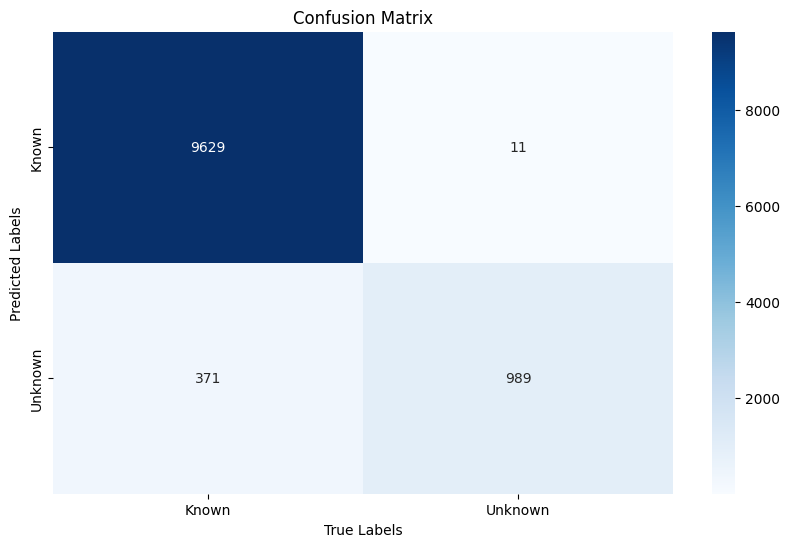

Accuracy (OOD, MNIST-test vs FMNIST and CIFAR10) : 96.5273 %


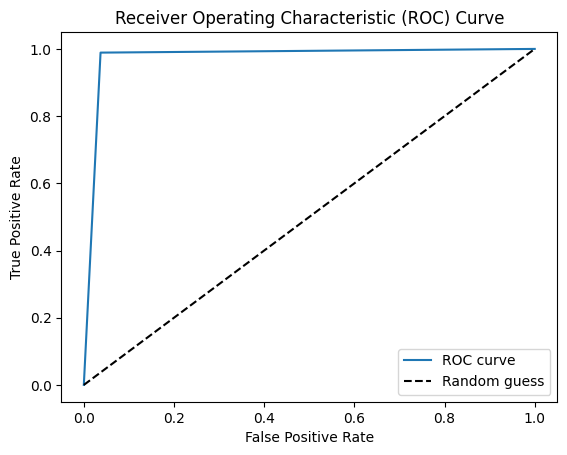

AUC (area under curve): 0.9759


In [ ]:
rocCurve(predicteds_convK_ood, predicteds_convU_ood, title=f'(OOD, {config.dataset}-test vs {config.unknown_dataset1} and {config.unknown_dataset2})')

#### Confusion Matrix, all the 11 classes

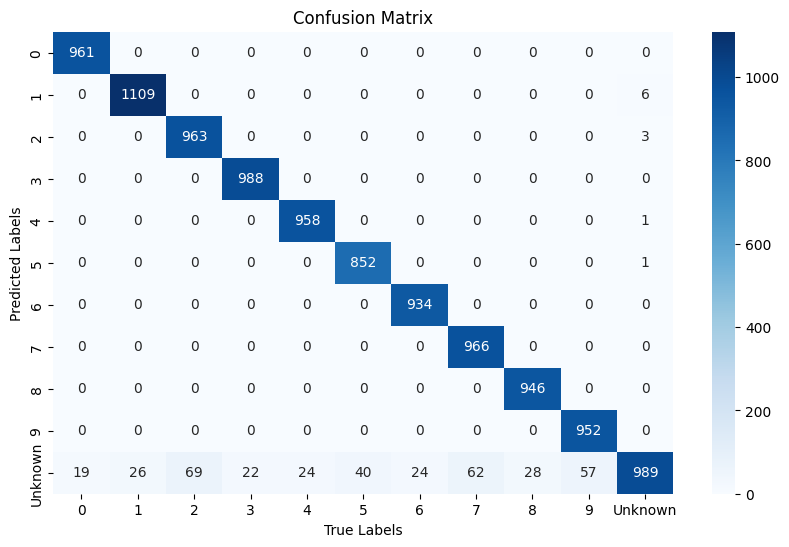

Accuracy (OOD, MNIST-test vs FMNIST and CIFAR10) : 96.5273 %


In [ ]:
confusionMatrix(np.hstack([predicteds_convK_ood, predicteds_convU_ood]), np.hstack([yK, yU]), title=f'(OOD, {config.dataset}-test vs {config.unknown_dataset1} and {config.unknown_dataset2})')

#### PCA and T-SNE Plots on the embedded data (10D logits)
PCA and T-SNE plots do not provide a clear understanding of how the data is separated in the logits space.

In our case, we discovered that the visualization techniques we employed were not successful in accurately distinguishing the unknown data when projected onto a two-dimensional (2D) space. However, upon analyzing the outcomes in the original ten-dimensional (10D) space, we observed that the unknown data exhibited better separation. This implies that relying solely on PCA and T-SNE visualizations may not adequately represent the ability of the logits space to effectively distinguish unknown data. This is particularly true in our situation, where we utilized Cross Entropy loss as subsequent steps in the process. We can observe that the out-of-distribution (OOD) data tends to be predominantly concentrated in the middle of the logit space. This pattern suggests that there is generally lower confidence associated with this type of data.

##### Without the unknown data

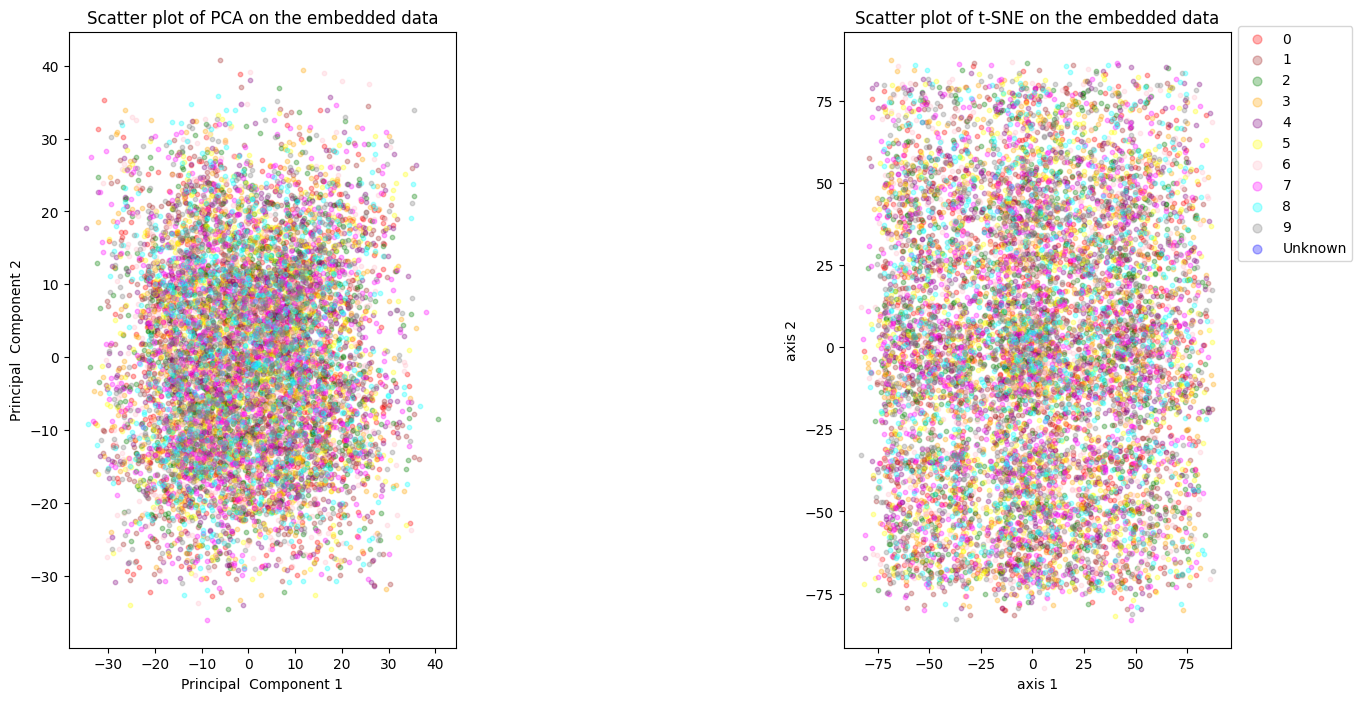

In [ ]:
pcaAndTsne(embeddings_logits_convK, yK, k=11)

##### With the unknown data

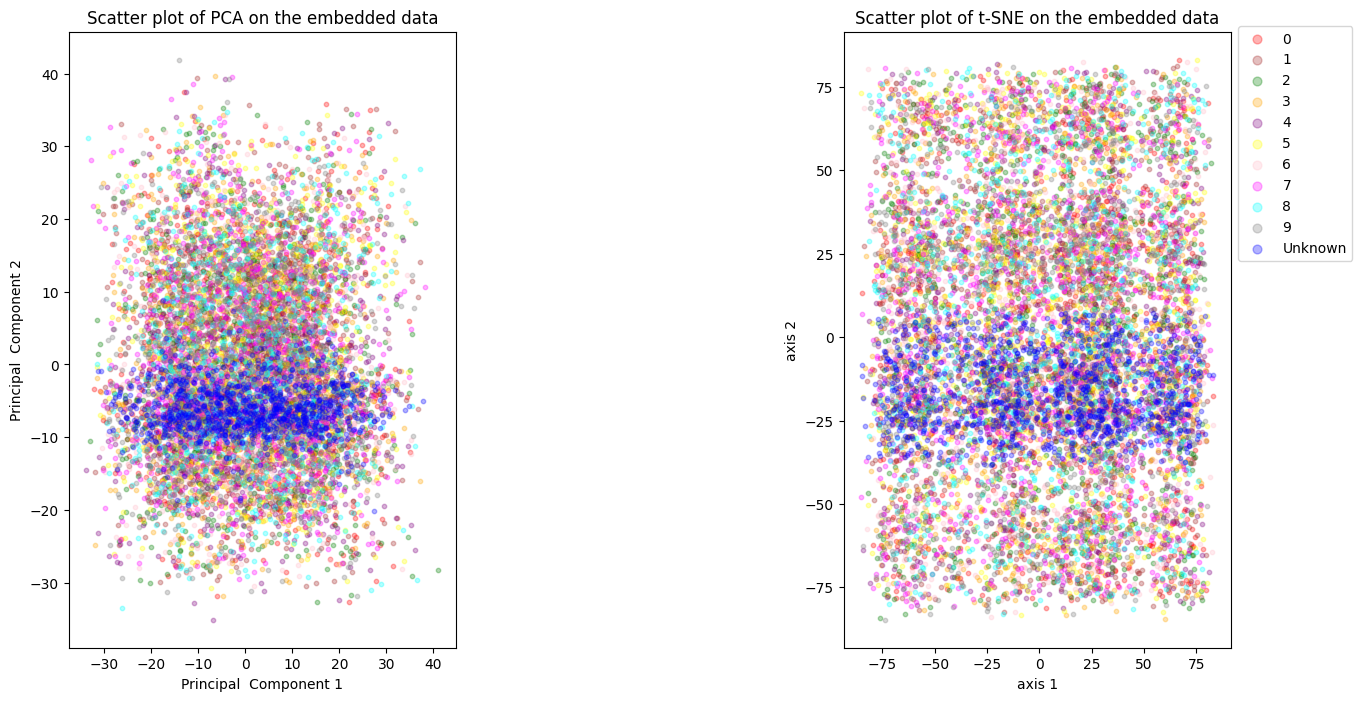

In [ ]:
ku = np.vstack((embeddings_logits_convK, embeddings_logits_convU))
y_ku = np.hstack((yK, yU))
pcaAndTsne(ku, y_ku, k=11)

#### Model Loss and Accuracy
For achieving better accuracy, we resumed the training using the open set classifier model.  

In the PDF format, the figure is in the supplementary section (last three pages).

![figure4](https://drive.google.com/uc?id=1SIDdJn-wDDirMm9On_9MERcr4Vn8nfGG)

## Testing Script

Testing script based on project_utils.py that was supplied.

 Please change the combined_loader according to your testing data (use your own loader or set a new ood_sampled_test_set using the ood variable, it can be CIFAR10 of FMNIST).

The models (two models in ensemble for the task) are loaded using the saved weights.

In [ ]:
ood = 'CIFAR10' # CIFAR10 FMNIST
print(f'OOD set is from {ood}:')
config_att = AttrDict(config)
train_dataset, _, mnist_test_set, transform_mnist_test_set = get_data('MNIST')
_ ,_ ,ood_test_set, ood_transform_test_set = get_data(ood) # FMNIST or CIFAR10


# sample ~500-2000 samples from OOD
num_samples = 1500
sampled_indices = torch.randperm(len(ood_test_set))[:num_samples]
ood_sampled_test_set = torch.utils.data.Subset(ood_test_set, sampled_indices)

# Combine the datasets
combined_ds = CombinedDataset(mnist_test_set, ood_sampled_test_set)
# large batchsize for inference is recommended
test_batch_size = 1024
train_loader = make_loader(train_dataset, test_batch_size)
mnist_test_loader = make_loader(mnist_test_set, test_batch_size)
combined_loader = make_loader(combined_ds, batch_size=test_batch_size)

# According to our experiments, 0.96 is the best threshold
threshold = 0.96
best_model_base = load_model_pth(device, open=False)
best_model_conv = load_model_pth(device, open=True)
# Baseline
acc_mnist, _, _, predicted_base = eval_model(best_model_base, best_model_conv, mnist_test_loader, device, ood_score_threshold=threshold, baseline=True)
print()
print(f'Baseline: MNIST Accuracy: {acc_mnist*100:.2f}%')
# OSR
acc_mnist, acc_ood, acc_total, predicted_osr = eval_model(best_model_base, best_model_conv, combined_loader, device, ood_score_threshold=threshold, baseline=False)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

OOD set is from CIFAR10:
Files already downloaded and verified
Loading model for close set:
==> Building Conv Network..
Loading model for open set:
==> Building Conv Network..

Baseline: MNIST Accuracy: 99.99%
MNIST Accuracy: 96.29%
OOD Accuracy: 99.87%
Total Accuracy: 96.76%


You can use the next cell to map the unknown class from class 10 (type: numpy array) to 'Unknown' (type: list). This is the mapping function from computer exercise 2.

In [ ]:
# mapping function, related to computer exercise 2
mapped_output_osr = map_output_to_label(predicted_osr)
unknown_cnt_ood = mapped_output_osr.count('Unknown')
print(f'Number of unknown data samples in the testing set - Predicted:{unknown_cnt_ood} , True: {num_samples}')

Number of unknown data samples in the testing set - Predicted:1869 , True: 1500


# Exporting to PDF

In [ ]:
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
# # from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
# !jupyter nbconvert --to pdf ./drive/MyDrive/Colab_Notebooks/GMDL/GMDL_PROJ/GMDL_PROJ.ipynb